In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("whitegrid")

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.cluster import KMeans
from sklearn import metrics
from datetime import datetime, timedelta

# Préparation

In [2]:
dataFull = pd.read_csv('olist_merged.csv')
dataFull['order_purchase_timestamp'] = pd.to_datetime(dataFull['order_purchase_timestamp'])

Mise en place de plusieurs fonctions pour notre comparaison de l'ARI.

In [3]:
def createDataframe(date):
    """Fonction permettant de créer un dataframe propre avec les informations Client - Montant - Recence - Frequence
    en prenant en compte seulement les commandes plus anciennes ou égales à la date passée en paramètre.
    J'applique le traitement des outliers de Montant directement ici également."""
    
    #On récupère seulement les commandes jusqu'à la date indiquée
    df = dataFull[dataFull['order_purchase_timestamp'] <= date]
    
    #Création du DataFrame de sortie
    dfDate = pd.DataFrame(columns=['Client'])
    dfDate['Client']=df['customer_unique_id'].unique()
    
    #Ajout du Montant
    groupbyTotalAmount = pd.DataFrame(df.drop_duplicates(subset='order_id', keep='first')
                                  .groupby('customer_unique_id')['total_payment_value']
                                  .sum())
    dfDate = pd.merge(dfDate, groupbyTotalAmount, left_on='Client', right_on='customer_unique_id', how='left')
    dfDate = dfDate.rename(columns={'total_payment_value': 'Montant'})
    
    #Ajout de la Recence
    groupbyLatestDate = pd.DataFrame(df.drop_duplicates(subset='order_id', keep='first').groupby('customer_unique_id')['order_purchase_timestamp'].max())
    dfDate = pd.merge(dfDate, groupbyLatestDate, left_on='Client', right_on='customer_unique_id', how='left')
    dfDate['Recence'] = (pd.to_datetime('2018-10-17 17:30:18') - dfDate['order_purchase_timestamp']).dt.days
    dfDate.drop('order_purchase_timestamp', axis=1, inplace=True)
   
    #Ajout de la Frequence
    groupbySumOrder = pd.DataFrame(df.drop_duplicates(subset='order_id', keep='first')
                               .groupby('customer_unique_id')['customer_unique_id']
                               .count()
                               .reset_index(name='Frequence'))
    dfDate = pd.merge(dfDate, groupbySumOrder, left_on='Client', right_on='customer_unique_id', how='left')
    dfDate.drop('customer_unique_id', axis=1, inplace=True)
    
    #Traitement des outliers de Montant
    dfDate.loc[:, 'Montant'] = np.minimum(dfDate['Montant'], 2000)
    
    return dfDate

In [4]:
def addDays(date, ndays):
    """Fonction qui prend en entrée une date sous forme de string, y ajoute un nombre de jour fournit également en entrée (int)
    et retourne la nouvelle date en format string"""
    
    #Changement du type de la data en entrée pour pouvoir faire la somme
    initial_date = datetime.strptime(date, '%Y-%m-%d')

    #Ajout des ndays à la date initiale
    new_date = initial_date + timedelta(days=ndays)

    #Transforme cette nouvelle date en string
    new_date_string = new_date.strftime('%Y-%m-%d')

    return new_date_string

In [5]:
def affichageARI(ARIs):
    """Fonction permettant l'affichage de notre liste de {date:ARI} sous forme de plot"""
    dates = []
    aris = []

    #Séparation des dates et des ARIs associées dans 2 listes différentes
    for entry in ARIs:
        date_str, ari_value = entry.popitem()
        dates.append(datetime.strptime(date_str, '%Y-%m-%d'))
        aris.append(ari_value)

    #Création de la figure
    plt.figure(figsize=(10, 6))
    plt.plot(dates, aris, marker='o', linestyle='-', color='b')

    #Ajout des derniers détails
    plt.title('ARI Evolution Over Time')
    plt.xlabel('Date')
    plt.ylabel('ARI Value')
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(dates, rotation=45, ha='right', rotation_mode='anchor')

    #Affichage de la figure
    plt.show()

In [6]:
def calculARI(date, ndays):
    """Fonction principale qui prend en entrée une date sous format string '2018-01-01' et un nombre de jour en int.
    La fonction va initialiser un modèle de clusterisation KMeans cls_T0 sur les données de la date initiale.
    On va ensuite boucler en augmentant la date de ndays et calculer le ARI entre la clusterisation effectuée via les données 
    de cette nouvelle date sur un nouveau modèle et la clusterisation de ces données sur le modèle initial."""
    ARIs = []
    
    #Création de notre dataframe à la date initiale T0
    df_T0 = createDataframe(date)
    X_T0 = df_T0[['Montant', 'Recence', 'Frequence']]
    
    #Entrainement du modèle à T0
    cls_T0 = Pipeline([
        ("preprocessor", MinMaxScaler()),
        ("KMeans", KMeans(n_clusters=4, random_state=0, n_init="auto"))
    ])
    cls_T0.fit(X_T0)
    
    #Tdate sera la date qui sera incrémentée à chaque itération
    Tdate = addDays(date, ndays)
    
    #Tant que la date est inférieur à la data maximale de notre jeu de données, on continue de calculer les ARI
    while(pd.to_datetime(Tdate) <= pd.to_datetime('2018-10-17 17:30:18')):
        #création du dataframe jusqu'à la Tdate de cette itération
        df_TX = createDataframe(Tdate)
        X_TX = df_TX[['Montant', 'Recence', 'Frequence']]

        #Entrainement du modèle à TX
        cls_TX = Pipeline([
            ("preprocessor", MinMaxScaler()),
            ("KMeans", KMeans(n_clusters=4, random_state=0, n_init="auto"))
        ])
        cls_TX.fit(X_TX)
        
        #Calcul des ARI entre T0 et TX
        ARI = metrics.adjusted_rand_score(cls_TX.predict(X_TX), cls_T0.predict(X_TX))
        print(ARI)
        ARIs.append({Tdate: ARI})
        
        #Incrémentation de la date
        Tdate = addDays(Tdate, ndays)
    
    #Affichage des résultats sous forme de plot
    affichageARI(ARIs)

# Simulation

0.8869264755518812
0.7707215225221511
0.694223177101945
0.6609232194559049
0.6412359142790274
0.6085112232552621
0.5261070828211715
0.40003642649187515
0.4068485925880562
0.4097678007866926
0.38932076346781735
0.384513267656162
0.3636722770837974
0.34991273595688904
0.2298795807992962
0.39116436510666047
0.22916957287191647
0.3878182828270678
0.3873991496675545


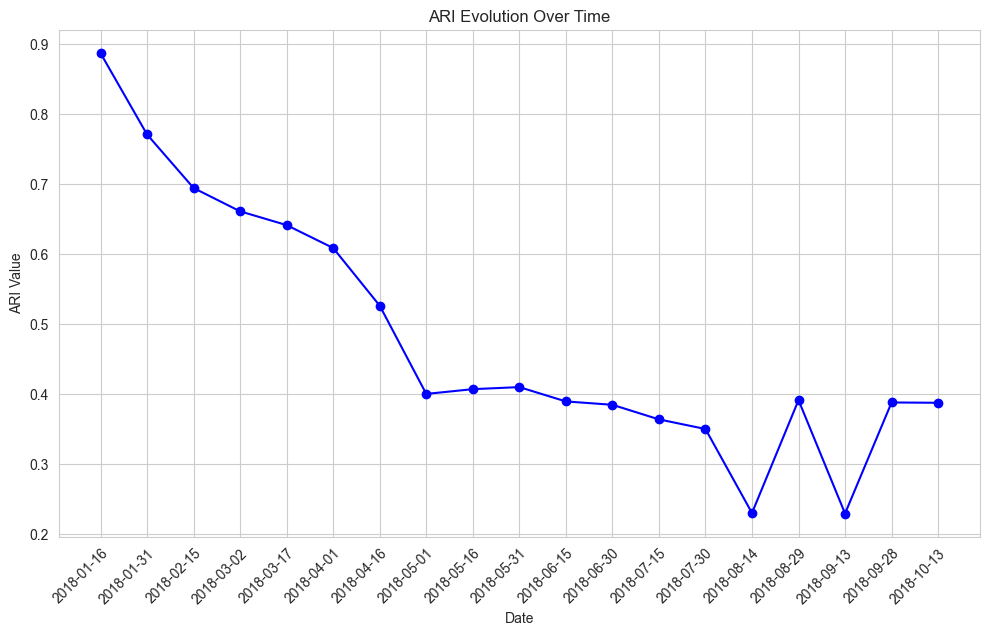

In [15]:
calculARI('2018-01-01', 15)

0.9243128678748503
0.8922399598327124
0.8524685095600957
0.7640560412133852
0.6577885074983806
0.5966757529176655
0.5620623646320516
0.523841953832147
0.4631089543960915
0.45496355752436524
0.44653615881628317
0.4538708439059226
0.45164171048972557


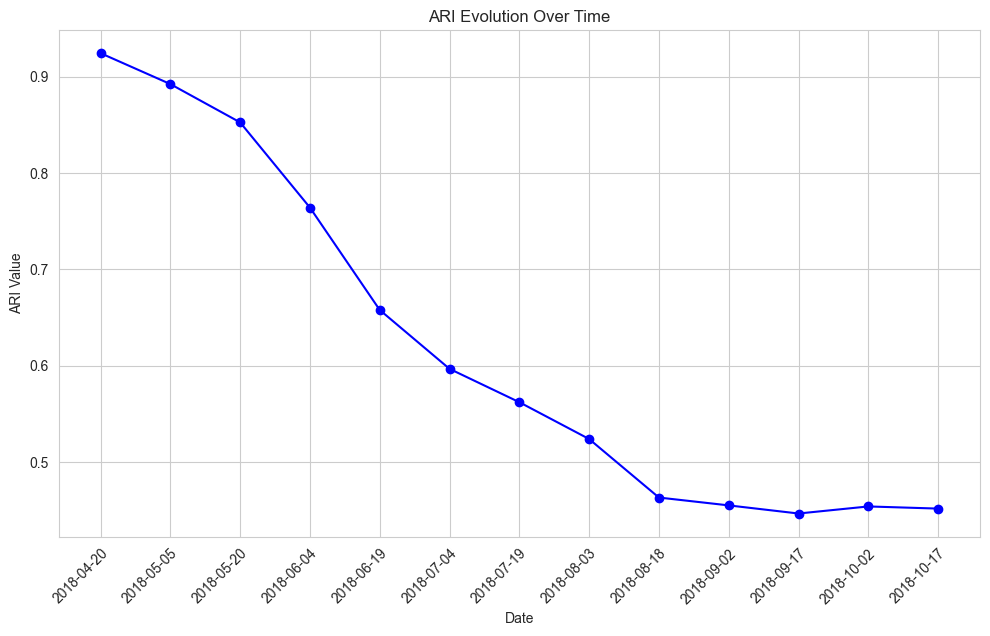

In [23]:
calculARI('2018-04-05', 15)

0.974056900040101
0.9400882286101249
0.5075620669111569
0.910728694934177
0.8922193360445086
0.8875912235427657
0.859944051088657
0.4701674149457997
0.7374791609698613
0.706808878273009
0.6592766656002006
0.4481238054098665
0.6056122880989083
0.5823370499138139
0.5567749740028738
0.5434397138431509
0.5198339014403021
0.48495319484553134
0.4553809037835534
0.4588882874660833
0.46821479061445853
0.45965158162611736
0.46251158570929973
0.46394537383604495
0.4675364733714677
0.4675364733714677


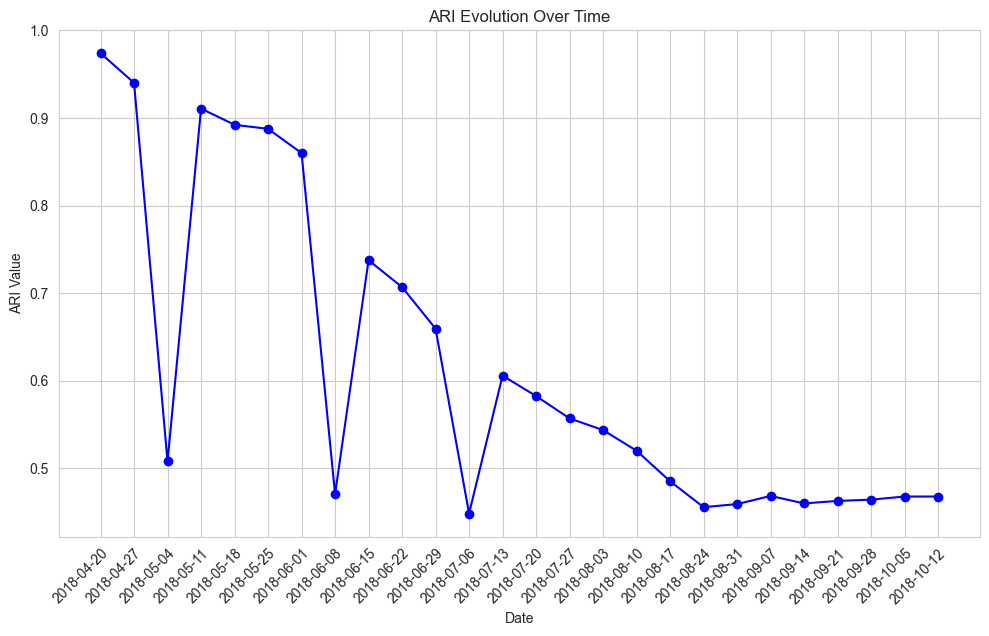

In [26]:
calculARI('2018-04-13', 7)